In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import random
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#Building model
from keras import layers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

#Outlier method
from Outlier_Detection.pyod.pyod.models.abod import ABOD 

# 1. Pre-processing

In [2]:
input_path = "./CY_Dataset/2021_04_21_test/2021_04_21_test.csv"
output_path = "./CY_Dataset/2021_04_21_test/"

#設定顯示到小數點後第幾位 (可以不用設，實際還是保留原本長度，只是顯示上會變短)
#pd.options.display.float_format = '{:.16f}'.format

#讀檔 (header需設為 None，預設以 index 0 為欄位名稱)
data = pd.read_csv(input_path,header=None)

#自定義 欄位名稱
column = ["file_name","f_1","f_2","f_3","f_4","f_5","f_6","f_7","f_8","f_9","f_10","label"]
data.columns = column

#正規化 -> 把不是 0 (false) 的全部變成 1 (true)，並產生一個新的 csv 。
with open(output_path + "test_regular.csv", 'w', newline='') as csvfile:
    
    writer = csv.writer(csvfile)
    
    #寫入欄位名稱
    writer.writerow(column)  
    
    for i in range(len(data)):
        
        if(data["label"][i] != 0):         #找出不是 0 的 label 值
            
            data["label"][i] = 1

        writer.writerow(data.loc[i])


<ipython-input-2-1d2ee4f612d9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label"][i] = 1


# 2. Noisy Data

In [3]:
regularfile_path = "./CY_Dataset/2021_04_21_test/test_regular.csv" 
output_path = "./CY_Dataset/2021_04_21_test/"

noisy_data = pd.read_csv(regularfile_path) #讀取正規化後的 csv。

noisy_number = 3000 #要污染的數量。  
noisy_index = random.sample(range(0,len(noisy_data)),noisy_number) #取 samle_number 個不重複隨機數
print("noisy rate : %.5f"%(noisy_number/len(noisy_data)),end='\n') #顯示污染比例
#反轉隨機 Sample 的 Label 值，並寫入 csv。
with open(output_path + "test_noisy.csv", 'w', newline='') as csvfile:
    
    writer = csv.writer(csvfile)
    
    #寫入欄位名稱
    writer.writerow(column)  
    
    for i in range(len(noisy_data)):
        
        if i in noisy_index:
            
            if(noisy_data["label"][i] == 0):         

                noisy_data["label"][i] = 1
                
            else:
            
                noisy_data["label"][i] = 0

        writer.writerow(noisy_data.loc[i])

noisy rate : 0.20631


<ipython-input-3-e2dbc743576a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noisy_data["label"][i] = 0
<ipython-input-3-e2dbc743576a>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noisy_data["label"][i] = 1


# Function：WS and DS

In [4]:
def dataset(data):
    
    # Whole Set
    WS_x = data.drop(["file_name","label"], axis = 1)
    WS_y = data["label"]

    #----------------------------------------------------------------------

    # Downsampling Set
    sample_number = 100
    index = random.sample(range(0,len(WS_x)),sample_number)     #取 samle_number 個 不重複隨機數
   
    DS_x = WS_x.loc[index]
    DS_y = WS_y.loc[index]

    #----------------------------------------------------------------------

    # df -> np
    WS_x = WS_x.values
    WS_y = WS_y.values
 
    DS_x = DS_x.values
    DS_y = DS_y.values
    
    return (WS_x,WS_y,DS_x,DS_y,index)

# Function：Building Model (validation)

In [19]:
def create_model_validation():
    
    # Creat model
    model = Sequential()
    model.add(Dense(500,input_dim=10,activation='relu'))
    model.add(Dense(1000,activation='relu'))
    model.add(Dense(1,activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# Function：Building Model

In [16]:
def create_model():
    
    model_input = layers.Input(shape=10)
    x = layers.Dense(500,activation='relu', kernel_initializer = 'normal')(model_input)
    x = layers.Dense(1000,activation='relu', kernel_initializer = 'normal')(x)
    model_output = layers.Dense(1,activation='softmax', kernel_initializer = 'normal')(x)
    
    return Model(model_input ,model_output)


# Function : Outlier Detection

In [7]:
def outlier_detection(loss):
    
    abod = ABOD().fit(loss)
    
    return abod.decision_function(loss)
    

# Main - 前置動作

In [24]:
iteration = 1      #噪聲標籤檢測迭代次數
epoch = 50         #訓練次數
WS_val_iter = []   #紀錄 k-fold validation (noise ratio)

#第一次先載入原始檔案，之後每次迭代都會用 Reverse 過後的資料。
noisy_path = "./CY_Dataset/2021_04_21_test/test_noisy.csv" #Noisy data path
data = pd.read_csv(noisy_path) #取得已經增加 Noise 的 Data。

# Main - 進入迭代

In [27]:
start = time.time() # 紀錄迭代開始的時間  
for i in range(iteration):  
    
    # 每次迭代都要清空 Loss 值
    WS_loss = []
    DS_loss = []
    concatenate_loss = []
    
    # 測試用
    WS_history = []
    DS_history = []
    
    
    # 初始化 DS 大小的陣列，用來存 Loss 值 (不取值，只取 Sample 數)。
    for k in range(len(dataset(data)[2])): #k值用來處理 loss 迴圈
    
        WS_loss.append([])
        DS_loss.append([])
        concatenate_loss.append([])
    
    #----------------------------------------------------------------------
    
    # Build_WS_model
    WS_model = create_model()
    WS_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #----------------------------------------------------------------------
    
    # Build_DS_model
    DS_model = create_model()
    DS_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #----------------------------------------------------------------------
    
    # 抓取 Data Set
    train_data = dataset(data) # 第一次迭代時的 Data 為還沒 Reverse 過的原始資料。
    WS_x = train_data[0]
    WS_y = train_data[1]
    DS_x = train_data[2]
    DS_y = train_data[3]

    #----------------------------------------------------------------------
    
    # Build_WS_model_validation
    WS_model_validation = KerasClassifier(build_fn=create_model_validation,epochs=50,batch_size=3000,verbose=0)
    
    # Shuffle data(k-fold validation)
    num_folds = 5
    kfold = StratifiedKFold(n_splits=num_folds,shuffle=True)
    
    # 計算分數
    score = cross_val_score(WS_model_validation,WS_x,WS_y,cv=kfold,scoring='accuracy').mean()
    WS_val_iter.append(1 - score)
    #print("\nNoise ratio : %.5f"%(1-score),end='\n\n')
    
    print("\nIteration : %d ==> Noise ratio : %.5f \n\nRunning...."%(i+1,1-score))
    
    #----------------------------------------------------------------------

    # Train_model
    
    for j in range(epoch):
        
        train_start = time.time()
  
        WS_history.append(WS_model.fit(WS_x,WS_y,epochs = 1, batch_size = 4000 , verbose = 0).history)
        DS_history.append(DS_model.fit(DS_x,DS_y,epochs = 1, batch_size = 4000 , verbose = 0).history)

        for k in range(len(DS_x)): # k值用來處理 loss 迴圈

            loss_x = DS_x[k].reshape(1,10)
            loss_y = DS_y[k].reshape(1,1)

        
            # 取出 loss 值
            WS_loss[k].append(WS_model.evaluate(loss_x,loss_y,verbose=0)[0])
            DS_loss[k].append(DS_model.evaluate(loss_x,loss_y,verbose=0)[0])
        
        train_end = time.time()
        
        if (epoch <= 25):
            
            print("\n Epoch : %d ... %.5f s"%(j+1,train_end - train_start),end="\n")
        
        elif((j+1) % 5 == 0):
            
            print("\n Epoch : %d ... %.5f s"%(j+1,train_end - train_start),end="\n")
            
    #----------------------------------------------------------------------
    
    # 合併 Loss 值
    for k in range(len(DS_x)): # k值用來處理 loss 迴圈
        
        concatenate_loss[k] = WS_loss[k] + DS_loss[k] 
    
    #----------------------------------------------------------------------
    
    # Outlier_detection (使用剛剛收集 DS 中每個 Sample 的 Loss 值)
    result = outlier_detection(concatenate_loss)
    
    
    
    
    #----------------------------------------------------------------------
    
    # Reverse_label
    
    
    
    #----------------------------------------------------------------------
    
# 處理結束
end = time.time()
print()
print("Total time : %8f s"%(end-start),end="\n")

/home/armin/anaconda3/envs/DT/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/home/armin/anaconda3/envs/DT/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/home/armin/anaconda3/envs/DT/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/home/armin/anaconda3/envs/DT/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/home/armin/anaconda3/envs/DT/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



Iteration : 1 ==> Noise ratio : 0.65044 

Running....

 Epoch : 5 ... 16.08377 s

 Epoch : 10 ... 17.01290 s

 Epoch : 15 ... 16.07481 s

 Epoch : 20 ... 16.34001 s

 Epoch : 25 ... 16.15457 s

 Epoch : 30 ... 15.17218 s

 Epoch : 35 ... 15.92049 s

 Epoch : 40 ... 16.62530 s

 Epoch : 45 ... 15.66130 s

 Epoch : 50 ... 15.63601 s

Total time : 863.979782 s


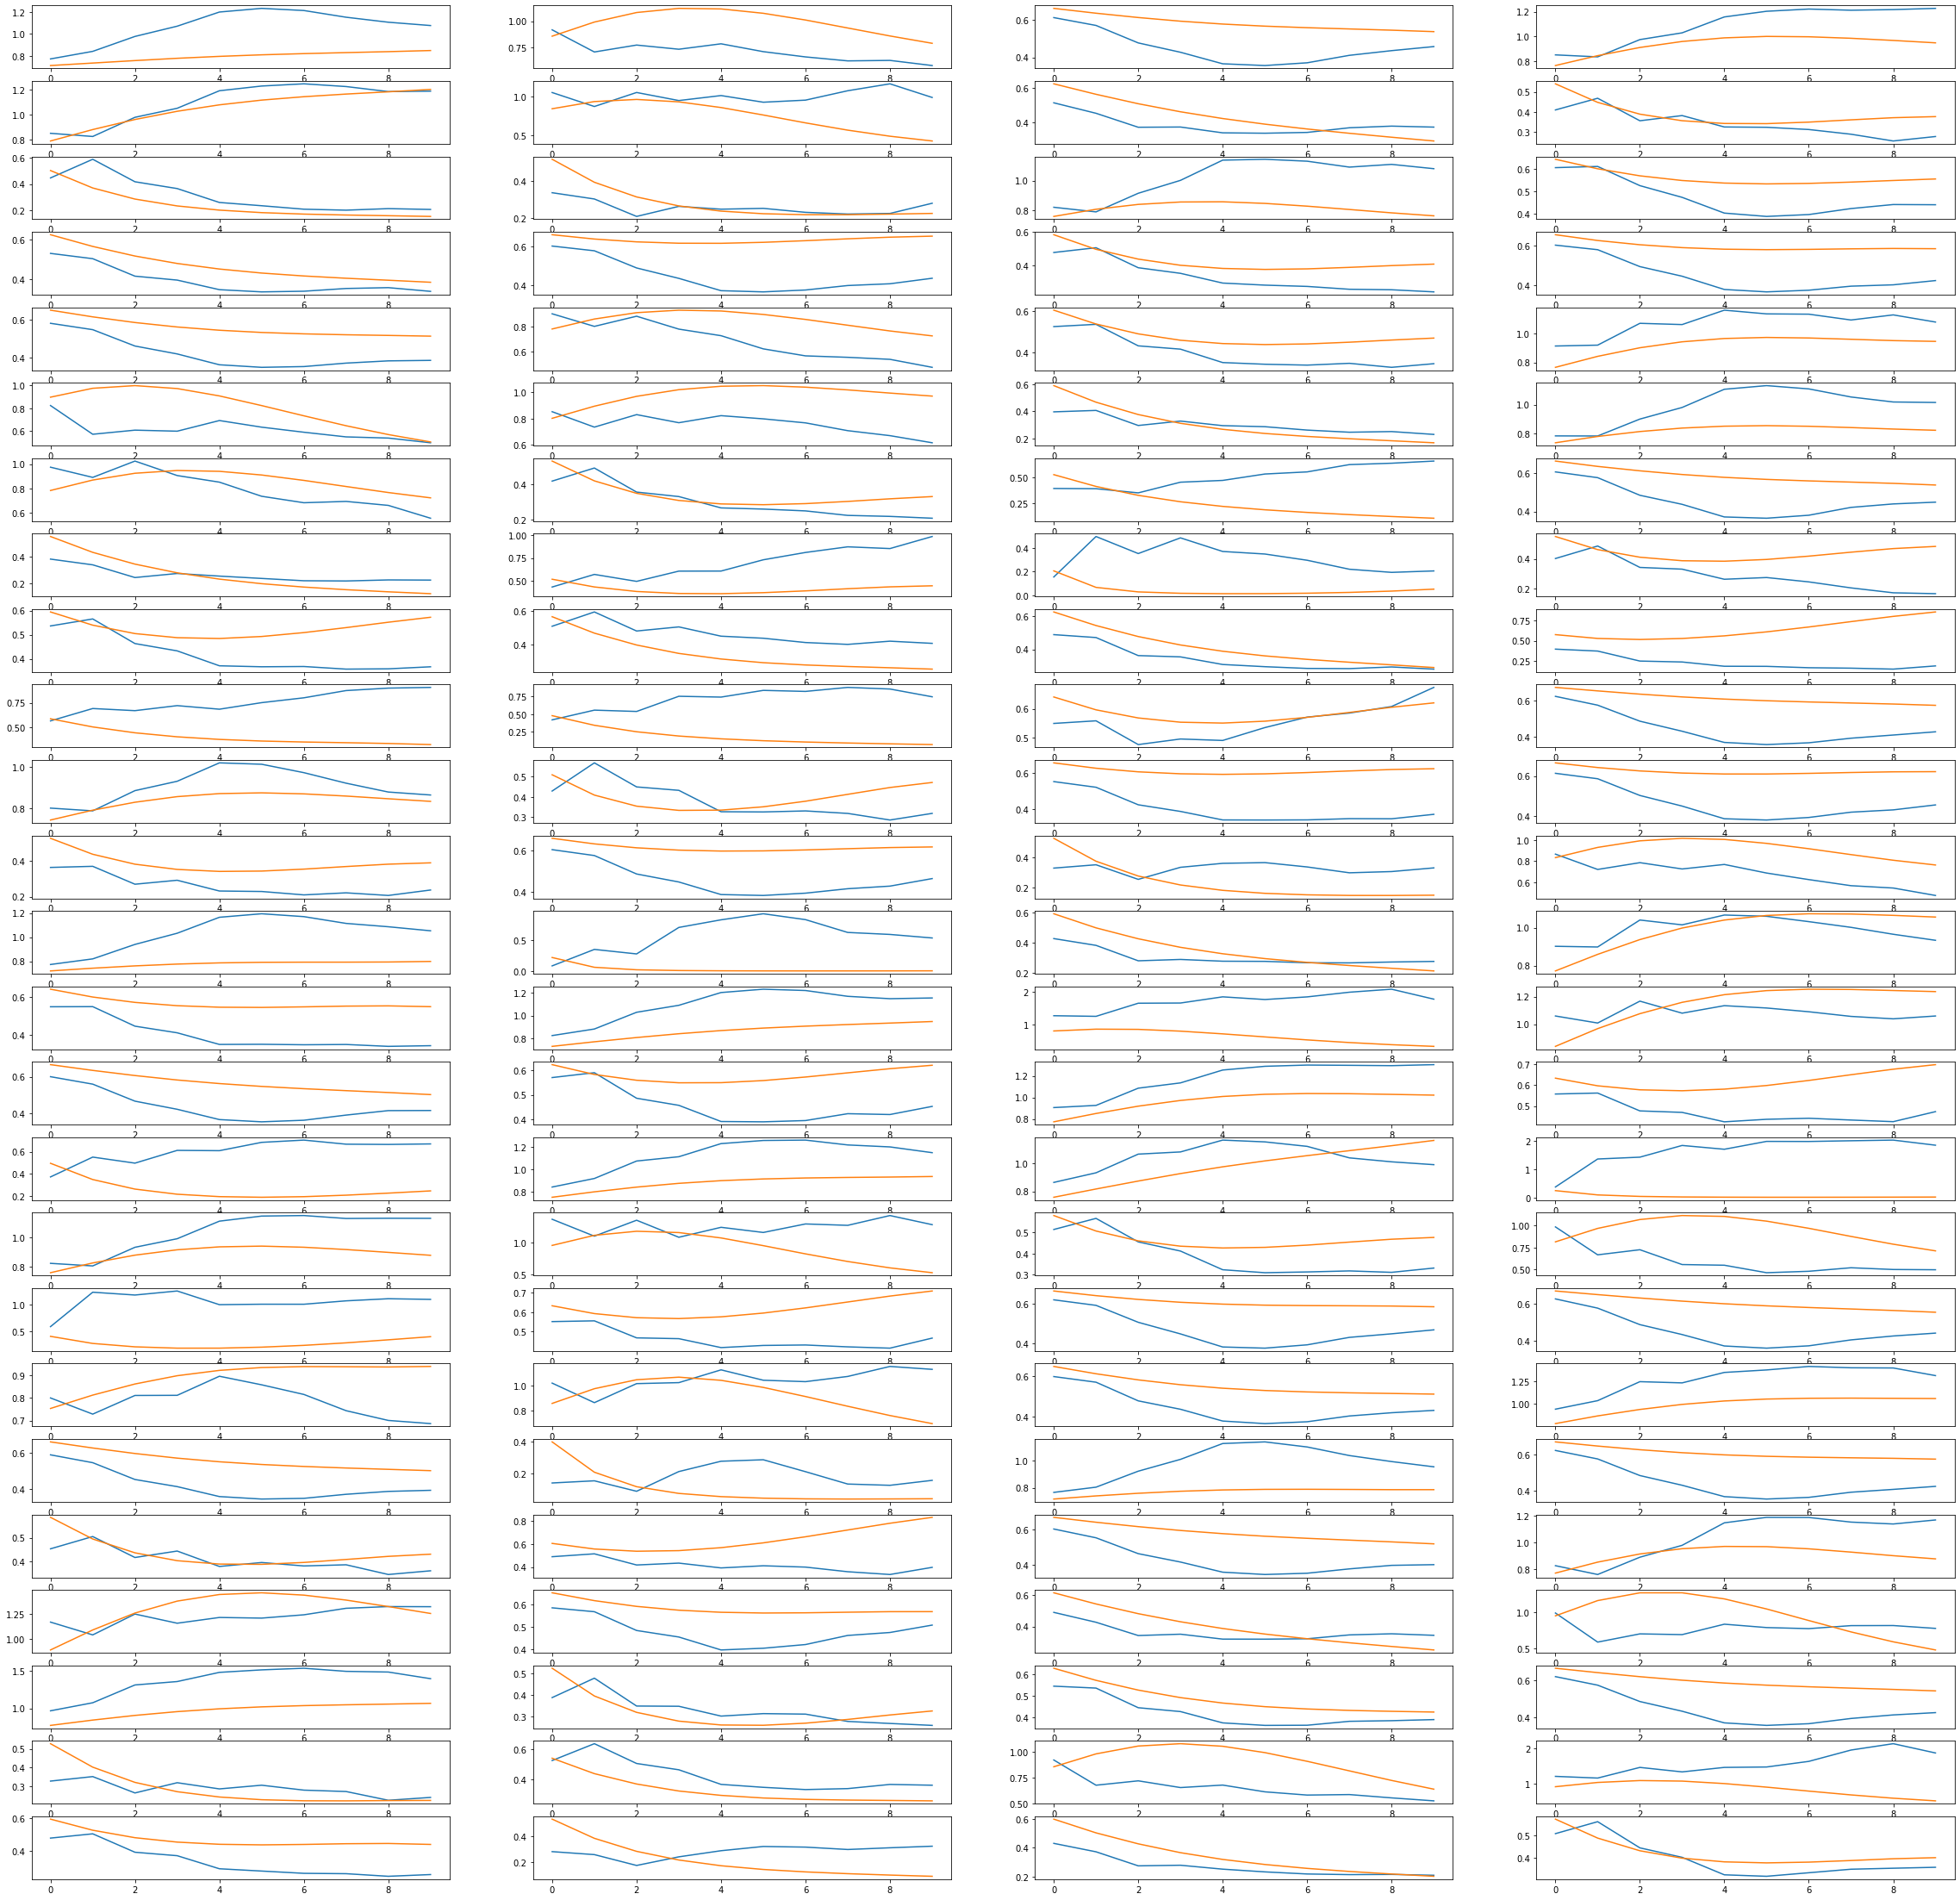




Fig. 0 : 0  Fig. 1 : 0  Fig. 2 : 0  Fig. 3 : 1  
Fig. 4 : 1  Fig. 5 : 1  Fig. 6 : 0  Fig. 7 : 0  
Fig. 8 : 0  Fig. 9 : 0  Fig.10 : 1  Fig.11 : 0  
Fig.12 : 0  Fig.13 : 0  Fig.14 : 0  Fig.15 : 0  
Fig.16 : 0  Fig.17 : 0  Fig.18 : 0  Fig.19 : 1  
Fig.20 : 0  Fig.21 : 0  Fig.22 : 0  Fig.23 : 1  
Fig.24 : 0  Fig.25 : 0  Fig.26 : 1  Fig.27 : 0  
Fig.28 : 0  Fig.29 : 1  Fig.30 : 1  Fig.31 : 0  
Fig.32 : 0  Fig.33 : 0  Fig.34 : 0  Fig.35 : 0  
Fig.36 : 1  Fig.37 : 0  Fig.38 : 1  Fig.39 : 0  
Fig.40 : 1  Fig.41 : 0  Fig.42 : 0  Fig.43 : 0  
Fig.44 : 0  Fig.45 : 0  Fig.46 : 0  Fig.47 : 0  
Fig.48 : 1  Fig.49 : 0  Fig.50 : 0  Fig.51 : 0  
Fig.52 : 0  Fig.53 : 1  Fig.54 : 1  Fig.55 : 1  
Fig.56 : 0  Fig.57 : 0  Fig.58 : 1  Fig.59 : 0  
Fig.60 : 0  Fig.61 : 1  Fig.62 : 0  Fig.63 : 0  
Fig.64 : 1  Fig.65 : 1  Fig.66 : 0  Fig.67 : 0  
Fig.68 : 0  Fig.69 : 0  Fig.70 : 0  Fig.71 : 0  
Fig.72 : 0  Fig.73 : 1  Fig.74 : 0  Fig.75 : 1  
Fig.76 : 0  Fig.77 : 0  Fig.78 : 0  Fig.79 : 0  
Fig.80 : 0  Fig.8

In [23]:
plt.figure(figsize = (40, 40)) 
for i in range(1,len(train_data[4])+1):
    
    plt.subplot(25,4,i)  

    plt.plot(WS_loss[i-1])
    plt.plot(DS_loss[i-1])

plt.show()  
l = 0
count = 0
print("\n\n")
for i in train_data[4]:
    
    if i in noisy_index:
        count+=1
        print("Fig.%2d : 1 "%(l),end = ' ')
    else:
        
        print("Fig.%2d : 0 "%(l),end = ' ')
    l+=1
    
    if l%4 == 0:
        print()
print("\n\n")
print(result)
print("\n\n ==> %d/%d (%.2f %%) \n"%(count,len(train_data[4]),(count/len(train_data[4]))*100))
# plt.plot(result)
# plt.xlabel("sample")
# plt.ylabel("value")
# plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

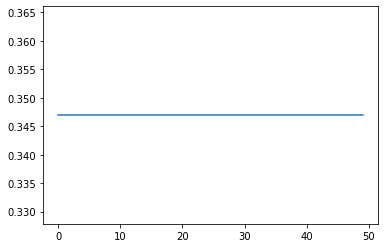

In [238]:
a = []
for i in WS_history:  
    a.append(i['accuracy'])
plt.plot(a)
plt.show